In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import matplotlib.pyplot as plt

In [3]:
from PIL import Image

In [5]:
import sys
sys.path.append("../figures")

from where import WhereFill, WhereShift, RetinaBackground, RetinaMask, RetinaWhiten 
from where import RetinaTransform, WhereNet, CollTransform, MNIST, Normalize, WhereTrainer, Where

In [6]:
from main import init
args = init(filename='../data/2019-06-12')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 1.0,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-05',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'what_offset_std': 5.0,
 'what_offset_max': 15}

In [7]:
from retina import Retina
retina = Retina(args)

Retina vectorizing...
ok


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/retina_6_24_10_2_1.41_128_transform.npy'

In [7]:
accuracy_map = np.load('../data/MNIST_accuracy.npy')

In [8]:
accuracy_map.min()

0.0145

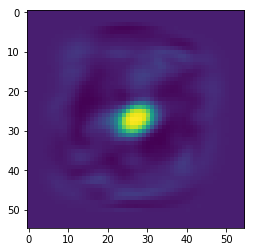

In [9]:
plt.imshow(accuracy_map)

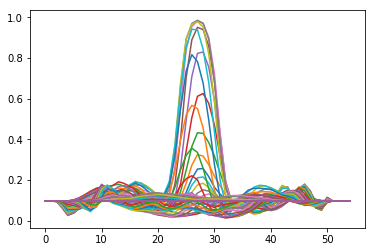

In [10]:
_ = plt.plot(accuracy_map)

## Unit tests

In [11]:
import math

In [12]:
i_offset = -18 #None #
j_offset = 18 #None #

In [13]:
transform=transforms.Compose([
                               WhereFill(N_pic=args.N_pic),
                               #WhereShift(args, theta=3*math.pi/4), 
                               #WhereShift(args, radius = 18), 
                               WhereShift(args, i_offset=i_offset, j_offset=j_offset),
                               RetinaBackground( contrast=args.contrast,
                                                 noise=args.noise,
                                                 sf_0=args.sf_0,
                                                 B_sf=args.B_sf),
                               RetinaMask(N_pic=args.N_pic),
                               RetinaWhiten(N_pic=args.N_pic),
                               RetinaTransform(retina.retina_transform_vector),
                               #Normalize()
                           ])

In [14]:
target_transform=transforms.Compose([
                               WhereFill(accuracy_map=accuracy_map, N_pic=args.N_pic),
                               #WhereShift(args, theta=3*math.pi/4, baseline = 0.1),
                               #WhereShift(args, radius = 18, baseline = 0.1),
                               WhereShift(args, i_offset=i_offset, j_offset=j_offset, baseline = 0.1),
                               CollTransform(retina.colliculus_transform_vector),
                           ])

In [15]:
dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        target_transform = target_transform,
                        )

In [16]:
len(dataset_train)

60000

In [17]:
train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [18]:
dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        target_transform = target_transform,
                        )

In [19]:
len(dataset_test)

10000

In [20]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [21]:
data, label = next(iter(train_loader))

In [22]:
data.shape

torch.Size([100, 2880])

In [23]:
#plt.imshow(data[i,:,:].detach().numpy())

In [24]:
label.shape

torch.Size([100, 240])

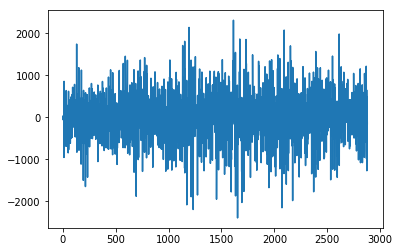

In [25]:
i = 4
plt.plot(data[i,:].detach().numpy())


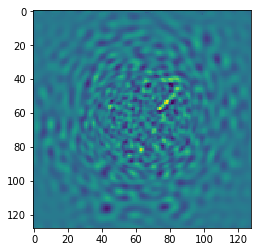

In [26]:
plt.imshow(retina.retina_invert(data[i,:].detach().numpy()))

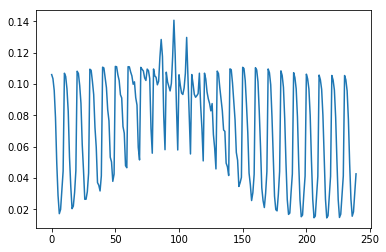

In [27]:
plt.plot(label[i,:].detach().numpy())

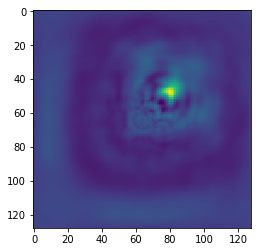

In [28]:
plt.imshow(retina.accuracy_invert(label[i,:].detach().numpy()))

(array([   7.,   12.,   65.,  218.,  720., 1469.,  280.,   88.,   15.,
           6.]),
 array([-2395.58148584, -1925.11441062, -1454.64733539,  -984.18026017,
         -513.71318495,   -43.24610972,   427.2209655 ,   897.68804073,
         1368.15511595,  1838.62219117,  2309.0892664 ]),
 <a list of 10 Patch objects>)

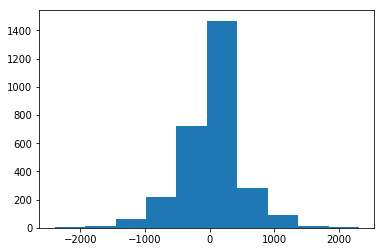

In [29]:
plt.hist(data[i,:].detach().numpy().flatten())

## WhereTrainer Class test

In [30]:
whereTrainer = WhereTrainer(args, generate_data=True)

Loading training dataset
Loading testing dataset


In [31]:
whereTrainer.model

WhereNet(
  (bn1): Linear(in_features=2880, out_features=1000, bias=True)
  (bn1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (bn2): Linear(in_features=1000, out_features=1000, bias=True)
  (bn2_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (bn3): Linear(in_features=1000, out_features=240, bias=True)
)

### Dataloader tests

#### TrainLoader

In [32]:
data, label = next(iter(whereTrainer.train_loader))

In [33]:
data_test, label_test = next(iter(train_loader))

In [34]:
len(whereTrainer.train_loader.dataset)

60000

In [35]:
len(whereTrainer.test_loader.dataset)

10000

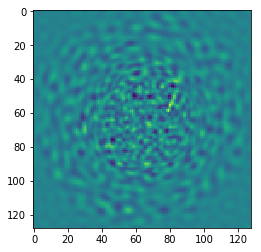

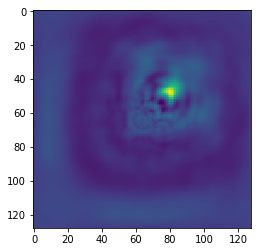

In [36]:
i = 3
plt.imshow(whereTrainer.retina.retina_invert(data_test[i,:].detach().numpy()))
plt.show()
plt.imshow(whereTrainer.retina.accuracy_invert(label_test[i,:].detach().numpy()))
plt.show()

#### TestLoader

In [37]:
data, data_fullfield, acc, acc_fullfield, labels = next(iter(whereTrainer.test_loader))

In [38]:
for batch_idx, (data, data_fullfield, acc, acc_fullfield, labels) in enumerate(whereTrainer.test_loader):
    print(batch_idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


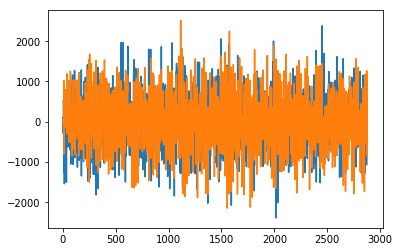

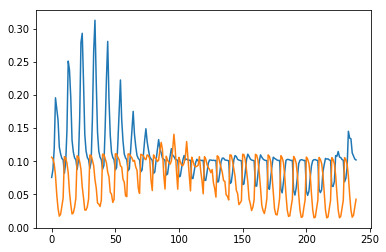

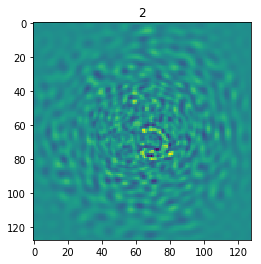

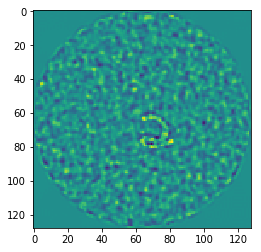

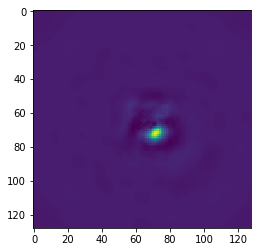

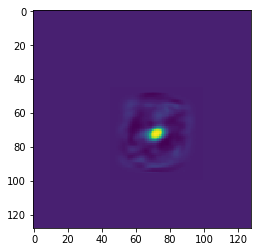

In [39]:
i = 3
plt.plot(data[i,:].detach().numpy())
plt.plot(data_test[i,:].detach().numpy())
plt.show()
plt.plot(acc[i,:].detach().numpy())
plt.plot(label_test[i,:].detach().numpy())
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data[i,:].detach().numpy()))
plt.title(labels[i].detach().numpy())
plt.show()
plt.imshow(data_fullfield[i,:].detach().numpy())
plt.show()
plt.imshow(whereTrainer.retina.accuracy_invert(acc[i,:].detach().numpy()))
plt.show()
plt.imshow(acc_fullfield[i,:].detach().numpy())
plt.show()

### Filters tests

In [40]:
data.shape

torch.Size([100, 2880])

In [41]:
acc.min()

tensor(0.0485, dtype=torch.float64)

In [42]:
data_float = data.float()

In [43]:
data_double = data_float.double()

In [44]:
data_np = data [i,:].detach().numpy()

In [45]:
data_float_np = data_float[i,:].detach().numpy()

In [46]:
data_double_np = data_double[i,:].detach().numpy()

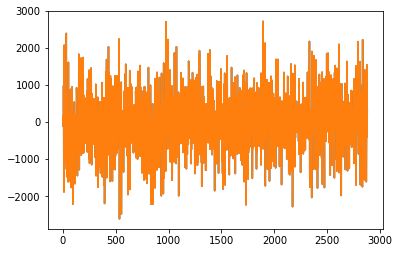

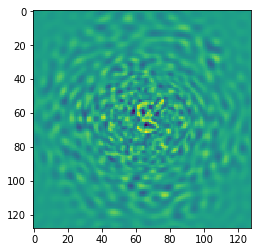

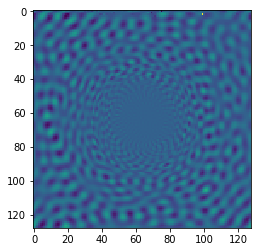

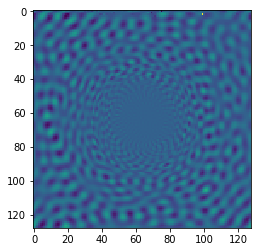

In [47]:
i = 0
plt.plot(data[i,:].detach().numpy())
plt.plot(data_float[i,:].detach().numpy())
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data[i,:].detach().numpy()))
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data_float[i,:].detach().numpy()))
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data_double[i,:].detach().numpy()))


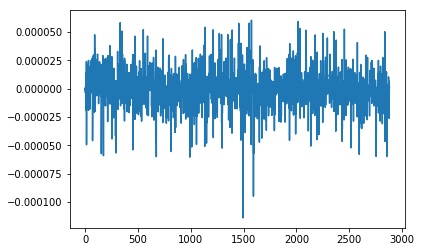

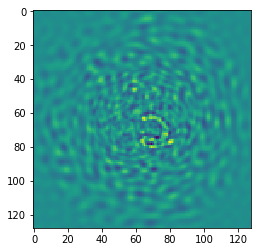

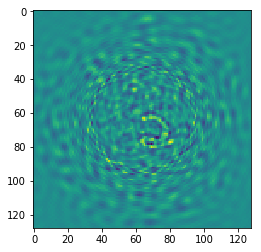

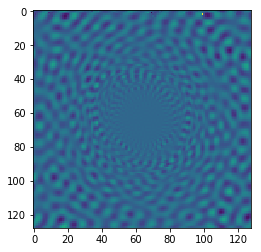

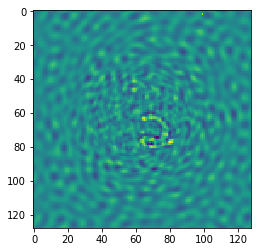

In [48]:
i = 0
diff = data_np - data_float_np
plt.plot(diff)
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data_np))
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data_np + 1e-10))
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data_np + diff))
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data_np + diff * 1e-5))


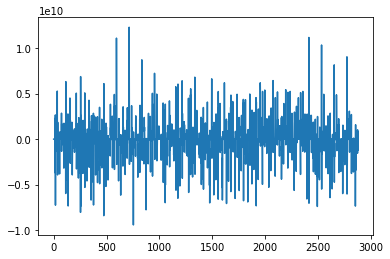

In [49]:
whereTrainer.retina.retina_inverse_transform.shape
plt.plot(whereTrainer.retina.retina_inverse_transform[0,:])
#plt.plot(whereTrainer.retina.retina_inverse_transform.flatten())


(2880, 16384)
(16384,)
0.0462646484375


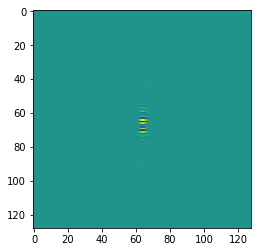

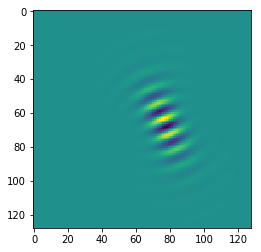

In [50]:
i = 0
print(whereTrainer.retina.retina_transform_vector.shape)
filter_test = whereTrainer.retina.retina_transform_vector[i,:]
print(filter_test.shape)
print(sum(abs(filter_test) > 1e-3) / (128*128))
#plt.plot(whereTrainer.retina.retina_inverse_transform.flatten())
plt.show()
plt.imshow(filter_test.reshape((128, 128)))
plt.show()
plt.imshow(whereTrainer.retina.retina_transform[4,5,5,1,:].reshape((128, 128)))

### Model  test

In [51]:
output = whereTrainer.model(torch.FloatTensor(data.float()).to('cpu'))

In [52]:
output.shape

torch.Size([100, 240])

In [53]:
output.max()

tensor(1.3756, grad_fn=<MaxBackward1>)

In [54]:
loss_func = torch.nn.BCEWithLogitsLoss()
loss = loss_func(output, label)

In [55]:
whereTrainer.loss_func

BCEWithLogitsLoss()

In [56]:
whereTrainer.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

In [57]:
if False:
    from where import train, test
    test(args, 
          whereTrainer.model, 
          "cpu", 
          whereTrainer.test_loader, 
          whereTrainer.loss_func) #, 
          #whereTrainer.optimizer, 
          #1)

In [58]:
if True:
    for epoch in range(1, args.epochs + 1):
        whereTrainer.train(epoch)
        whereTrainer.test()

Train Epoch: 1/60 [0/60000 (0%)]	Loss: 0.706710
Train Epoch: 1/60 [10000/60000 (17%)]	Loss: 0.658294
Train Epoch: 1/60 [20000/60000 (33%)]	Loss: 0.538199
Train Epoch: 1/60 [30000/60000 (50%)]	Loss: 0.428519
Train Epoch: 1/60 [40000/60000 (67%)]	Loss: 0.407857
Train Epoch: 1/60 [50000/60000 (83%)]	Loss: 0.383132

Test set: Average loss: 0.3912

Train Epoch: 2/60 [0/60000 (0%)]	Loss: 0.392797
Train Epoch: 2/60 [10000/60000 (17%)]	Loss: 0.393612
Train Epoch: 2/60 [20000/60000 (33%)]	Loss: 0.384982
Train Epoch: 2/60 [30000/60000 (50%)]	Loss: 0.394431
Train Epoch: 2/60 [40000/60000 (67%)]	Loss: 0.381998
Train Epoch: 2/60 [50000/60000 (83%)]	Loss: 0.387475

Test set: Average loss: 0.3904

Train Epoch: 3/60 [0/60000 (0%)]	Loss: 0.388137
Train Epoch: 3/60 [10000/60000 (17%)]	Loss: 0.397159
Train Epoch: 3/60 [20000/60000 (33%)]	Loss: 0.383544
Train Epoch: 3/60 [30000/60000 (50%)]	Loss: 0.395255
Train Epoch: 3/60 [40000/60000 (67%)]	Loss: 0.377865
Train Epoch: 3/60 [50000/60000 (83%)]	Loss: 0.38

Train Epoch: 24/60 [30000/60000 (50%)]	Loss: 0.381402
Train Epoch: 24/60 [40000/60000 (67%)]	Loss: 0.384971
Train Epoch: 24/60 [50000/60000 (83%)]	Loss: 0.371893

Test set: Average loss: 0.3882

Train Epoch: 25/60 [0/60000 (0%)]	Loss: 0.377973
Train Epoch: 25/60 [10000/60000 (17%)]	Loss: 0.378156
Train Epoch: 25/60 [20000/60000 (33%)]	Loss: 0.385066
Train Epoch: 25/60 [30000/60000 (50%)]	Loss: 0.382810
Train Epoch: 25/60 [40000/60000 (67%)]	Loss: 0.390867
Train Epoch: 25/60 [50000/60000 (83%)]	Loss: 0.376870

Test set: Average loss: 0.3882

Train Epoch: 26/60 [0/60000 (0%)]	Loss: 0.392565
Train Epoch: 26/60 [10000/60000 (17%)]	Loss: 0.377205
Train Epoch: 26/60 [20000/60000 (33%)]	Loss: 0.380841
Train Epoch: 26/60 [30000/60000 (50%)]	Loss: 0.385992
Train Epoch: 26/60 [40000/60000 (67%)]	Loss: 0.383204
Train Epoch: 26/60 [50000/60000 (83%)]	Loss: 0.376387

Test set: Average loss: 0.3883

Train Epoch: 27/60 [0/60000 (0%)]	Loss: 0.375434
Train Epoch: 27/60 [10000/60000 (17%)]	Loss: 0.38538

Train Epoch: 47/60 [50000/60000 (83%)]	Loss: 0.383260

Test set: Average loss: 0.3877

Train Epoch: 48/60 [0/60000 (0%)]	Loss: 0.374469
Train Epoch: 48/60 [10000/60000 (17%)]	Loss: 0.377808
Train Epoch: 48/60 [20000/60000 (33%)]	Loss: 0.374719
Train Epoch: 48/60 [30000/60000 (50%)]	Loss: 0.386281
Train Epoch: 48/60 [40000/60000 (67%)]	Loss: 0.381832
Train Epoch: 48/60 [50000/60000 (83%)]	Loss: 0.379518

Test set: Average loss: 0.3877

Train Epoch: 49/60 [0/60000 (0%)]	Loss: 0.382778
Train Epoch: 49/60 [10000/60000 (17%)]	Loss: 0.379467
Train Epoch: 49/60 [20000/60000 (33%)]	Loss: 0.380215
Train Epoch: 49/60 [30000/60000 (50%)]	Loss: 0.384066
Train Epoch: 49/60 [40000/60000 (67%)]	Loss: 0.382213
Train Epoch: 49/60 [50000/60000 (83%)]	Loss: 0.384409

Test set: Average loss: 0.3878

Train Epoch: 50/60 [0/60000 (0%)]	Loss: 0.381636
Train Epoch: 50/60 [10000/60000 (17%)]	Loss: 0.382814
Train Epoch: 50/60 [20000/60000 (33%)]	Loss: 0.382773
Train Epoch: 50/60 [30000/60000 (50%)]	Loss: 0.37742

In [65]:
from where import where_suffix
suffix = where_suffix(args)
model_path = '/tmp/where_model_{}.pt'.format(suffix)
torch.save(whereTrainer.model, model_path) 
print('Model saved at', model_path)

Model saved at /tmp/where_model__0.1_0.1_1.0_0.7_15_40_6_24_10_2_1.41_128.pt


In [66]:
whereTrainer.test()


Test set: Average loss: 0.3876



0.3876117005944252

## Where Tests

In [67]:
where = Where(args, generate_data=True, trainer=whereTrainer)

In [68]:
where.test()

0.0974

## Dataset generation

In [63]:
if False:
    for i, (data, label) in enumerate(train_loader):
        print(i, (i+1) * args.minibatch_size)
        if i == 0:
            full_data = data
            full_label = label
        else:
            full_data = torch.cat((full_data, data), 0)
            full_label = torch.cat((full_label, label), 0)

In [64]:
dataset = TensorDataset(full_data, full_label)
data_loader = DataLoader(dataset, batch_size=args.minibatch_size)

NameError: name 'full_data' is not defined

In [ ]:
full_data.shape

In [ ]:
data, label = next(iter(data_loader))

In [ ]:
data.shape

In [ ]:
plt.plot(label[i,:].detach().numpy())

In [ ]:
np.random.seed(26722)
np.random.randn()

In [ ]:
from display import pe, minmax
minmax(-15, 10)